# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Цель исследования:** построить модель МО, которая поможет определить регион, гдн добыча нефти принесет наибольшую прибыль. Посчитать риски и прибыль для каждого региона с помощью техники Bootstrap

**Условия задачи:**
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Описание данных:**
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Загрузка и подготовка данных

In [55]:
region_1 = pd.read_csv('/datasets/geo_data_0.csv')
region_2 = pd.read_csv('/datasets/geo_data_1.csv')
region_3 = pd.read_csv('/datasets/geo_data_2.csv')

### Общая информация об исходных данных

In [56]:
region_1.info()
region_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [57]:
region_2.info()
region_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [58]:
region_3.info()
region_3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


### Проверка на дубликаты

In [59]:
region_1.drop('id', axis=1).duplicated().sum()

0

In [60]:
region_2.drop('id', axis=1).duplicated().sum()

0

In [61]:
region_3.drop('id', axis=1).duplicated().sum()

0

In [62]:
region_1['id'].duplicated().sum()

10

In [63]:
region_2['id'].duplicated().sum()

4

In [64]:
region_3['id'].duplicated().sum()

4

### Исследовательский анализ

#### Регион 1

In [65]:
region_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


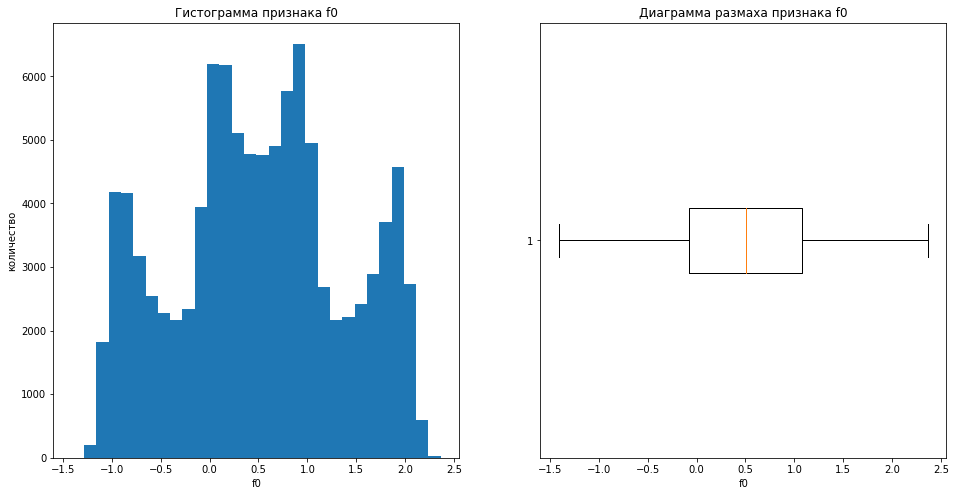

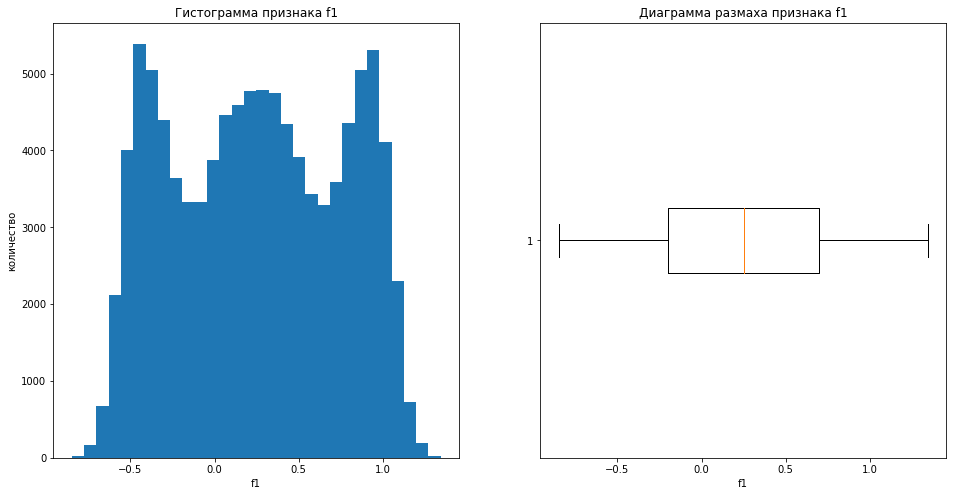

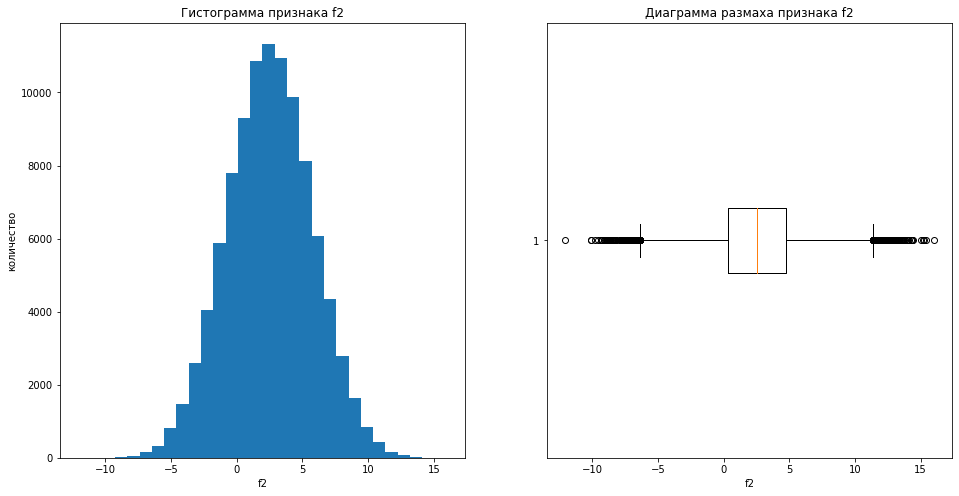

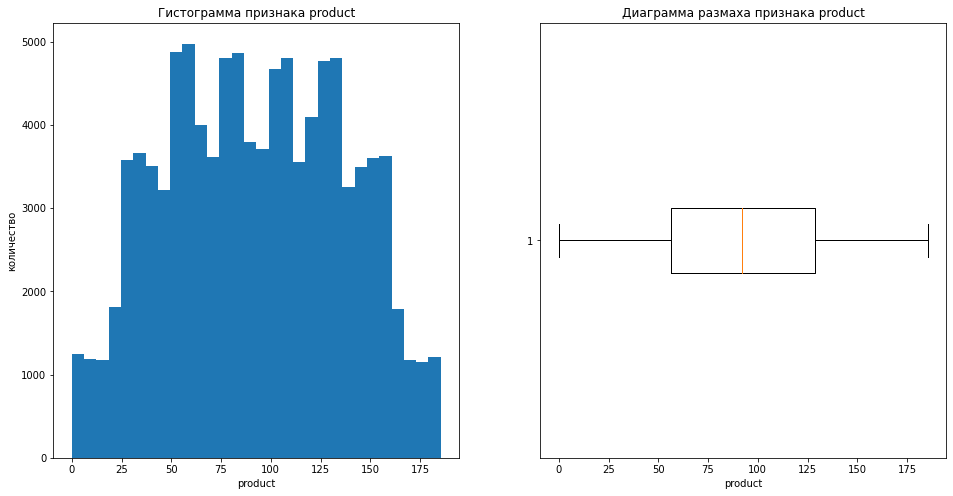

In [66]:
for col in region_1.select_dtypes(exclude='object').columns:
    fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
    ax[0].hist(data=region_1, x=col, bins=30)
    ax[0].set_title(f'Гистограмма признака {col}')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('количество')
    ax[1].boxplot(data=region_1, x=col, vert=False)
    ax[1].set_title(f'Диаграмма размаха признака {col}')
    ax[1].set_xlabel(col)
    plt.show()

#### Регион 2

In [67]:
region_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


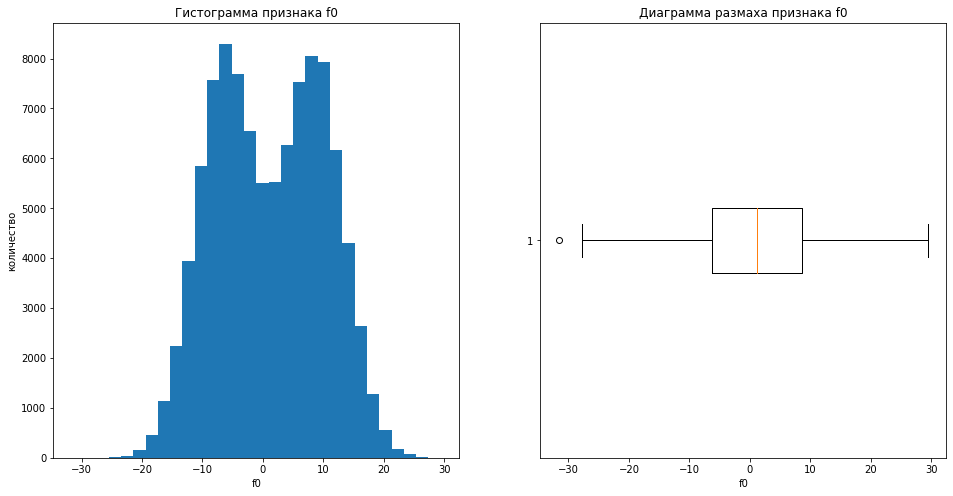

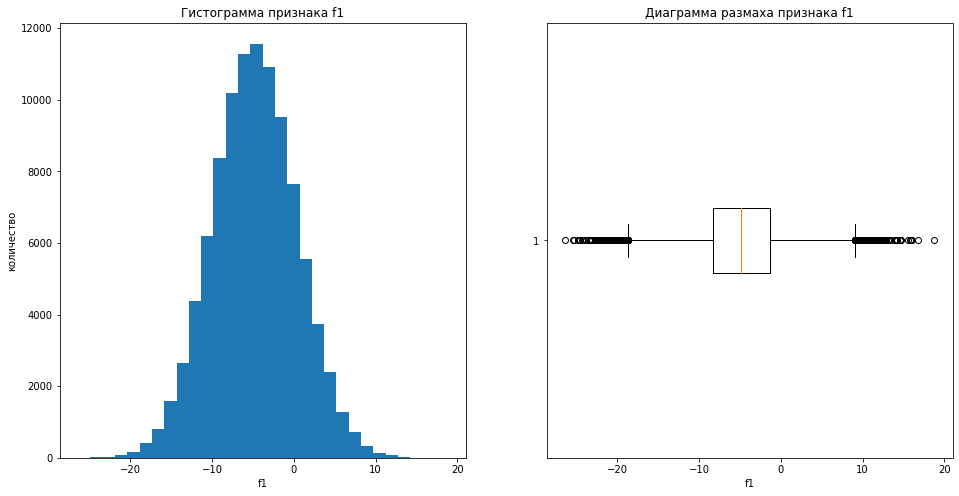

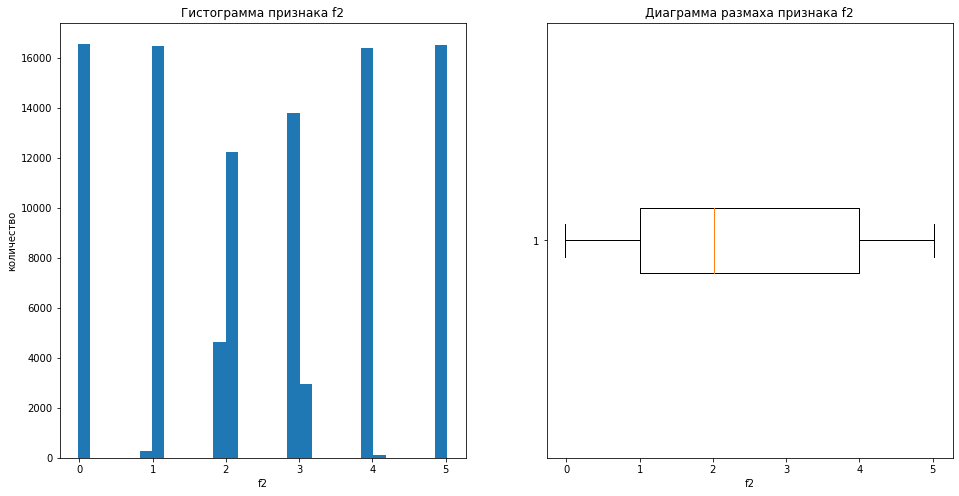

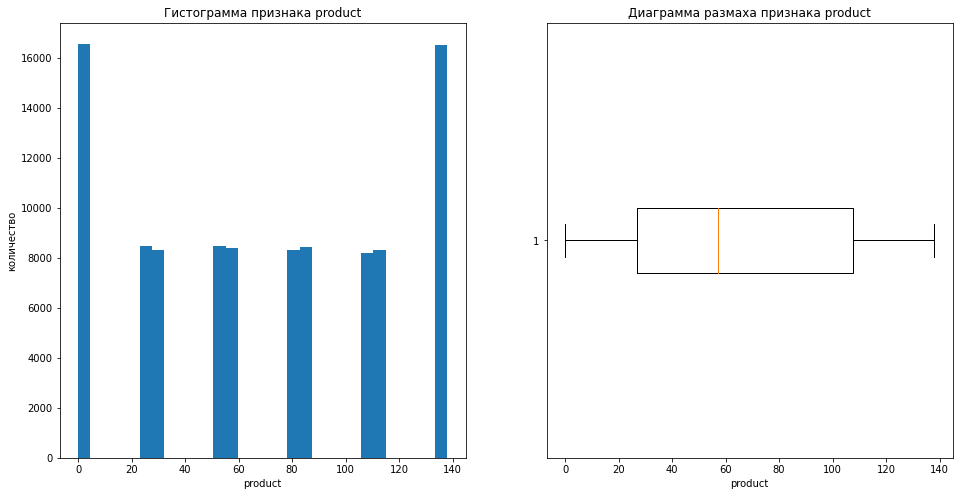

In [68]:
for col in region_2.select_dtypes(exclude='object').columns:
    fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
    ax[0].hist(data=region_2, x=col, bins=30)
    ax[0].set_title(f'Гистограмма признака {col}')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('количество')
    ax[1].boxplot(data=region_2, x=col, vert=False)
    ax[1].set_title(f'Диаграмма размаха признака {col}')
    ax[1].set_xlabel(col)
    plt.show()

#### Регион 3

In [69]:
region_3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


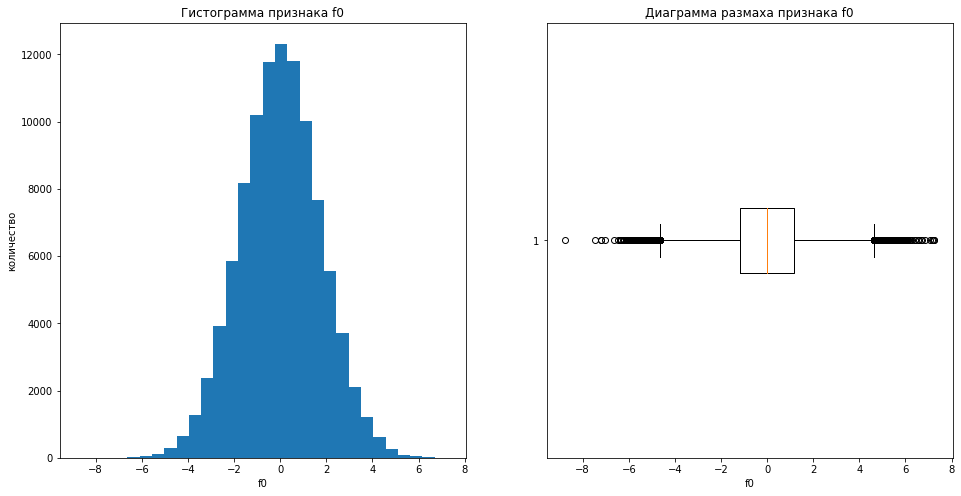

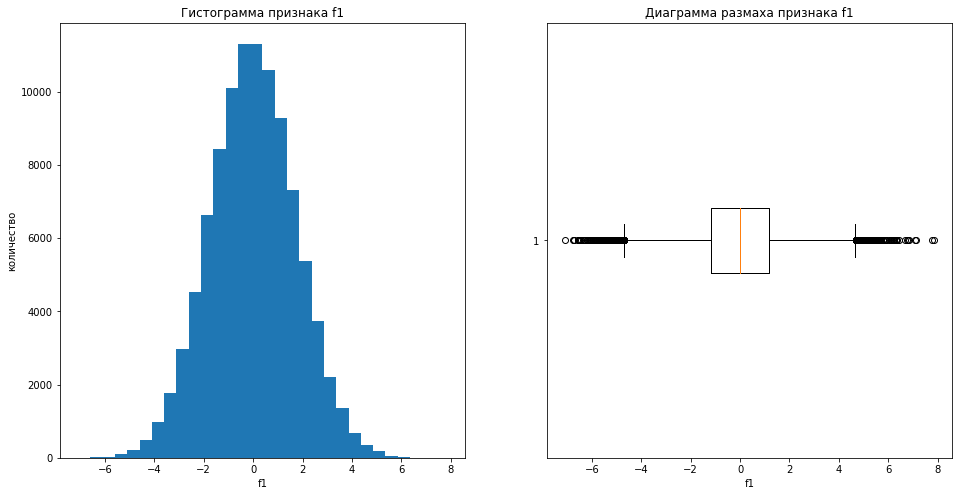

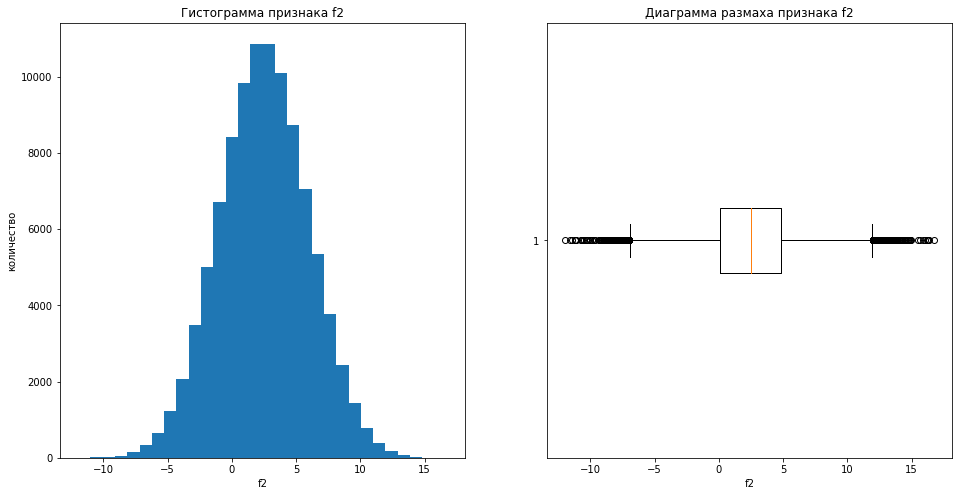

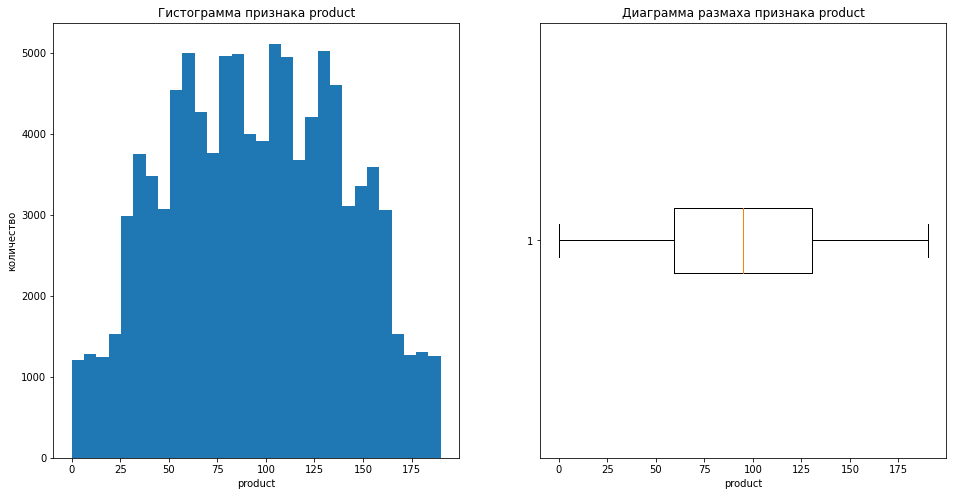

In [70]:
for col in region_3.select_dtypes(exclude='object').columns:
    fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
    ax[0].hist(data=region_3, x=col, bins=30)
    ax[0].set_title(f'Гистограмма признака {col}')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('количество')
    ax[1].boxplot(data=region_3, x=col, vert=False)
    ax[1].set_title(f'Диаграмма размаха признака {col}')
    ax[1].set_xlabel(col)
    plt.show()

### Корреляционный анализ

#### Регион 1

In [71]:
region_1.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


#### Регион 2

In [72]:
region_2.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


#### Регион 3

In [73]:
region_3.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


### Вывод

На данном этапе были загружены и изучены исходные датасеты. Проверены дубликаты, в каждом из регионов обнаружены строки с одинаковым id скважин, но разными признаками - их немного, поэтому решено оставить как есть. В *регионе 1* признаки f0, f1 распределены ненормально - имеют два пика, признак f2 имеет выбросы. В *регионе 2* признаки f0, f2 и целевой признак распределены ненормально, признак f1 имеет выбросы. В *регионе 3* все признаки распределены нормально, все входные признаки имееют выбросы. В регионе 2 обнаружена сильная корреляция признака f2 с целевым признаком. И распределения этих признаков вызывают сомнения. Возможно, следует не учитывать этот признак для МО.

## Обучение и проверка модели

In [74]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Регион 1

In [75]:
#разбиваем данные на обучающую и валидационную выборки
X1 = region_1.drop(['id', 'product'], axis=1)
y1 = region_1['product']
X1_train, X1_valid, y1_train, y1_valid = train_test_split(
    X1,
    y1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [76]:
#масштабируем входные признаки
scaler1 = StandardScaler()
X1_train_scaled = scaler1.fit_transform(X1_train)
X1_valid_scaled = scaler1.transform(X1_valid)

In [77]:
#объявляем, обучаем модель
model1 = LinearRegression()
model1.fit(X1_train_scaled, y1_train)
#делаем предсказания на валидационной выборке
pred1 = model1.predict(X1_valid_scaled)
print(f'Средний запас предсказанного сырья: {pred1.mean()}\n\
RMSE модели: {mean_squared_error(y1_valid, pred1, squared=False)}')


Средний запас предсказанного сырья: 92.39879990657768
RMSE модели: 37.75660035026169


### Регион 2

In [78]:
#разбиваем данные на обучающую и валидационную выборки
X2 = region_2.drop(['id', 'product'], axis=1)
y2 = region_2['product']
X2_train, X2_valid, y2_train, y2_valid = train_test_split(
    X2,
    y2,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [79]:
#масштабируем входные признаки
scaler2 = StandardScaler()
X2_train_scaled = scaler2.fit_transform(X2_train)
X2_valid_scaled = scaler2.transform(X2_valid)

In [80]:
#объявляем, обучаем модель
model2 = LinearRegression()
model2.fit(X2_train_scaled, y2_train)
#делаем предсказания на валидационной выборке
pred2 = model2.predict(X2_valid_scaled)
print(f'Средний запас предсказанного сырья: {pred2.mean()}\n\
RMSE модели: {mean_squared_error(y2_valid, pred2, squared=False)}')


Средний запас предсказанного сырья: 68.7128780391376
RMSE модели: 0.8902801001028846


### Регион 3

In [81]:
#разбиваем данные на обучающую и валидационную выборки
X3 = region_3.drop(['id', 'product'], axis=1)
y3 = region_3['product']
X3_train, X3_valid, y3_train, y3_valid = train_test_split(
    X3,
    y3,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [82]:
#масштабируем входные признаки
scaler3 = StandardScaler()
X3_train_scaled = scaler3.fit_transform(X3_train)
X3_valid_scaled = scaler3.transform(X3_valid)

In [83]:
#объявляем, обучаем модель
model3 = LinearRegression()
model3.fit(X3_train_scaled, y3_train)
#делаем предсказания на валидационной выборке
pred3 = model3.predict(X3_valid_scaled)
print(f'Средний запас предсказанного сырья: {pred3.mean()}\n\
RMSE модели: {mean_squared_error(y3_valid, pred3, squared=False)}')


Средний запас предсказанного сырья: 94.77102387765939
RMSE модели: 40.145872311342174


### Вывод

Наибольший средний запас предсказанного сырья в регионе 3 - 94.77, наименьшая среднеквадратичная ошибка в регионе 2 - ~34.96~ 0.89

## Подготовка к расчёту прибыли

In [84]:
N = 500 #точек для исследования
BEST = 200 #лучшие точки из исследованных
BUDGET = 10 * 10 ** 9 #выделенный бюджет
PROFIT = 450000 #доход с единиы продукта
LOSS = .025 #пороговое значение вероятности убытков

In [85]:
#рассчитываем объем сырья для безубыточной разработки
volume = BUDGET / BEST / PROFIT
print(f'Необходимый объем сырья для безубыточной разработки скважины: {volume}')

Необходимый объем сырья для безубыточной разработки скважины: 111.11111111111111


**Вывод**  
В каждом регионе среднее значение сырья предсказанного моделями меньше необходимого (111.1) для безубыточной разработки

## Расчёт прибыли и рисков 

In [86]:
#создаем функцию для расчета прибыли по лучшим скважинам из выборки
def income(data, target, prob, count):
    data['target'] = target
    data['prob'] = prob
    data = data.sort_values(by='prob', ascending=False)[:count]
    return round(data['target'].sum() * PROFIT - BUDGET, 1)

In [87]:
#используем технику Bootstrap для нахождения распределения прибыли для регионов
state = np.random.RandomState(12345)

income1 = []
for i in range(1000):
    subsample = X1_valid.sample(N, replace=True, random_state=state)
    income1.append(income(subsample, y1_valid, pd.Series(pred1, index = X1_valid.index), BEST))

In [88]:
income2 = []
for i in range(1000):
    subsample = X2_valid.sample(N, replace=True, random_state=state)
    income2.append(income(subsample, y2_valid, pd.Series(pred2, index = X2_valid.index), BEST))

In [89]:
income3 = []
for i in range(1000):
    subsample = X3_valid.sample(N, replace=True, random_state=state)
    income3.append(income(subsample, y3_valid, pd.Series(pred3, index = X3_valid.index), BEST))

### Регион 1

In [90]:
print(f'Cредняя прибыль 1го региона: {round(pd.Series(income1).mean(), 1)}')

Cредняя прибыль 1го региона: 406278783.4


In [91]:
print(f'95%-й доверительный интервал 1го региона: ({round(pd.Series(income1).quantile(LOSS), 1)}, {round(pd.Series(income1).quantile(1 - LOSS), 1)})')

95%-й доверительный интервал 1го региона: (-117742136.5, 911737050.8)


In [92]:
print(f'Вероятность убытков: {round((len([i for i in income1 if i < 0]) / len(income1)) * 100, 2)} %')

Вероятность убытков: 6.7 %


### Регион 2

In [93]:
print(f'Cредняя прибыль 2го региона: {round(pd.Series(income2).mean(), 1)}')

Cредняя прибыль 2го региона: 441504277.6


In [94]:
print(f'95%-й доверительный интервал 2го региона: ({round(pd.Series(income2).quantile(LOSS), 1)}, {round(pd.Series(income2).quantile(1 - LOSS), 1)})')

95%-й доверительный интервал 2го региона: (35728489.3, 828006639.0)


In [95]:
print(f'Вероятность убытков: {round((len([i for i in income2 if i < 0]) / len(income2)) * 100, 2)} %')

Вероятность убытков: 1.6 %


### Регион 3

In [96]:
print(f'Cредняя прибыль 3го региона: {round(pd.Series(income3).mean(), 1)}')

Cредняя прибыль 3го региона: 385213195.9


In [97]:
print(f'95%-й доверительный интервал 3го региона: ({round(pd.Series(income3).quantile(LOSS), 1)}, {round(pd.Series(income3).quantile(1 - LOSS), 1)})')

95%-й доверительный интервал 3го региона: (-164785166.1, 888206234.2)


In [98]:
print(f'Вероятность убытков: {round((len([i for i in income3 if i < 0]) / len(income3)) * 100, 2)} %')

Вероятность убытков: 7.8 %


### Вывод

По условию заказчика вероятность убытков должна быть меньше 2.5%, ~ни один регион не удовлетворяет этому условию. Если все же выбирать регион для разработки скважин, то наилучшим по средней прибыли оказался регион 1 с вероятностью убытков 6.7%.~ получается рекомендовать заказчику можно регион 2 с вероятностью убытков в 1.6%. Также средняя прибыль этого региона оказалась наибольшей.

## Общий вывод

На подготовительном этапе были загружены и изучены исходные датасеты. Проверены дубликаты, в каждом из регионов обнаружены строки с одинаковым id скважин, но разными признаками - их немного, поэтому решено оставить как есть. В *регионе 1* признаки f0, f1 распределены ненормально - имеют два пика, признак f2 имеет выбросы. В *регионе 2* признаки f0, f2 и целевой признак распределены ненормально, признак f1 имеет выбросы. В *регионе 3* все признаки распределены нормально, все входные признаки имееют выбросы. В регионе 2 обнаружена сильная корреляция признака f2 с целевым признаком. И распределения этих признаков вызывают сомнения. Возможно, следует не учитывать этот признак для МО.  
Далее была построена линейная модель для предсказания объема запасов сырья в скважинах. Наибольший средний запас предсказанного сырья в регионе 3 - 94.77, наименьшая среднеквадратичная ошибка в регионе 2 - 0.89.
Был рассчитан достаточный объём сырья для безубыточной разработки новой скважины. В каждом регионе среднее значение сырья предсказанного моделями оказалось меньше необходимого (111.1) для безубыточной разработки.  
По выбранным скважинам и предсказаниям модели была написана функция для рассчета прибыли для полученного объема сырья. При помощи техники Bootstrap определили распределение прибыли для каждого региона, среднюю прибыль, 95%-й доверительный интервал, вероятность убытков. По условию заказчика вероятность убытков должна быть меньше 2.5%, получается рекомендовать заказчику можно регион 2 с вероятностью убытков в 1.6%. Также средняя прибыль этого региона оказалась наибольшей

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован